<a href="https://colab.research.google.com/github/talhaanwarch/my_pytorch/blob/master/advance/3D_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [2]:
%%capture
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install "monai-weekly[nibabel]"
!pip install -U pytorch-lightning
!pip install torchmetrics
!pip install -U tqdm
%matplotlib inline

In [3]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-1ffeec40-8c47-f749-8ca2-3450c0bccf52)


In [4]:
import tqdm
print(tqdm.__version__)
assert tqdm.__version__ >='4.47.0', 'tqdm version >=4.47.0'

4.61.2


In [5]:
#download data
import os
if os.path.isfile('Task09_Spleen.tar') is False:
  !wget https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar

--2021-07-14 10:10:27--  https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar
Resolving msd-for-monai.s3-us-west-2.amazonaws.com (msd-for-monai.s3-us-west-2.amazonaws.com)... 52.218.193.113
Connecting to msd-for-monai.s3-us-west-2.amazonaws.com (msd-for-monai.s3-us-west-2.amazonaws.com)|52.218.193.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1610352640 (1.5G) [application/x-tar]
Saving to: ‘Task09_Spleen.tar’

Task09_Spleen.tar   100%[===================>]   1.50G  21.7MB/s    in 72s     

2021-07-14 10:11:39 (21.5 MB/s) - ‘Task09_Spleen.tar’ saved [1610352640/1610352640]



In [6]:
import tarfile
if os.path.isdir('Task09_Spleen') is False:
  my_tar = tarfile.open('/content/Task09_Spleen.tar')
  my_tar.extractall('/content/')
  my_tar.close()

In [7]:
from glob import glob
import os
images = sorted(glob("Task09_Spleen/imagesTr/*.nii.gz"))
segs = sorted(glob("Task09_Spleen/labelsTr/*.nii.gz"))
data_dicts = [
            {"image": image_name, "label": label_name}
            for image_name, label_name in zip(images, segs)
        ]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [8]:
import nibabel as nib
for i in range(len(train_files)):
  img = nib.load(train_files[i]['image']).get_fdata()
  lab = nib.load(train_files[i]['label']).get_fdata()
  print(img.shape,lab.shape)
  break

(512, 512, 55) (512, 512, 55)


In [44]:
import nibabel as nib
val_data=[]
for i in range(len(val_files)):
  img = nib.load(val_files[i]['image']).get_fdata()
  lab = nib.load(val_files[i]['label']).get_fdata()
  val_data.append((img,lab))
  

In [10]:
from  monai import transforms as T
train_transforms = T.Compose(
            [
        T.LoadImaged(keys=["image", "label"]),
        T.AddChanneld(keys=["image", "label"]),
        T.Spacingd(keys=["image", "label"],pixdim=(1.5, 1.5, 2.0),mode=("bilinear", "nearest")),
        T.ScaleIntensityd(keys=["image"]),
        T.CropForegroundd(keys=["image", "label"], source_key="image"),
        T.RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(64, 64, 64),
            pos=1,
            neg=1,
            num_samples=8,
            image_key="image",
            image_threshold=0,
        ),
        T.ToTensord(keys=["image", "label"]),
            ]
        )



post_trans = T.Compose(
    [T.ToTensor(), T.Activations(sigmoid=True), T.AsDiscrete(threshold_values=True)]
)

In [11]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from monai.losses import DiceLoss
from torch.utils.data import DataLoader, Dataset
from monai.data import CacheDataset, list_data_collate
from pytorch_lightning.loggers import TensorBoardLogger
from monai.networks.nets import UNet
import torch.nn as nn
import torch
import torchmetrics


In [12]:
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference

class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer = UNet(
                      dimensions=3,
                      in_channels=1,
                      out_channels=2,
                      channels=(16, 32, 64, 128, 256),
                      strides=(2, 2, 2, 2),
                      num_res_units=2,
                      norm=Norm.BATCH,
                  )

  #parameters
    self.lr=1e-4
    self.bs=16
    self.numworker=2
    self.criterion=DiceLoss(to_onehot_y=True, softmax=True)
    self.metrics = torchmetrics.IoU(num_classes=2)
  def forward(self,x):
    return self.layer(x)


  def configure_optimizers(self):
    opt=torch.optim.Adam(self.parameters(), lr=self.lr)
    return opt

  def train_dataloader(self):
    ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0, num_workers=self.numworker)
    loader=DataLoader(ds, batch_size=self.bs, shuffle=True,num_workers=self.numworker, collate_fn=list_data_collate)
    return loader

  def training_step(self,batch,batch_idx):
    image,segment=batch["image"], batch["label"]
    out=self(image)
    loss=self.criterion(out,segment)

    self.log('train/loss', loss, on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    ds = CacheDataset(data=val_files, transform=train_transforms,cache_rate=1.0, num_workers=self.numworker)
    loader=DataLoader(ds, batch_size=self.bs, shuffle=False,num_workers=self.numworker, collate_fn=list_data_collate)
    return loader
    
  def validation_step(self,batch,batch_idx):
    image,segment=batch["image"], batch["label"]
    roi_size = (32, 32, 32)
    sw_batch_size = 2
    outputs = sliding_window_inference(image, roi_size, sw_batch_size, self.forward)
    loss=self.criterion(outputs,segment)
    iou=self.metrics(outputs.type(torch.float),segment.type(torch.long))
    self.log('val/loss', loss, on_epoch=True,prog_bar=True)
    self.log('val/iou', iou, on_epoch=True,prog_bar=True)
    return loss


In [13]:
model = OurModel()
# logger = TensorBoardLogger("logs", name="my_logs")
# checkpoint_callback = ModelCheckpoint(monitor='val/loss',dirpath='/content/drive/MyDrive/',
#                                       filename='spleen200' )
# trainer = Trainer(max_epochs=600, auto_lr_find=False, auto_scale_batch_size=False,
#                   #tpu_cores=8,precision=16,
#                   gpus=-1,
#                   logger=logger,
#                   progress_bar_refresh_rate=30,
#                   #resume_from_checkpoint='/content/drive/MyDrive/spleen200-v1.ckpt',
#                   callbacks=[checkpoint_callback]
#                   )

In [14]:
#trainer.fit(model)

In [15]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/spleen_state600.pt')

# inference

In [16]:
model.load_state_dict(torch.load('/content/drive/MyDrive/spleen_state600.pt'))


<All keys matched successfully>

In [17]:
post_transforms = T.Compose([
        T.ToTensord(keys="pred"), 
        T.Activationsd(keys="pred", sigmoid=True),
        T.AsDiscreted(keys="pred", threshold_values=True),
        T.Invertd(
            keys=["pred",'label'],  # invert the `pred` data field, also support multiple fields
            transform=train_transforms,
            orig_keys="image",  # get the previously applied pre_transforms information on the `img` data field,
                              # then invert `pred` based on this information. we can use same info
                              # for multiple fields, also support different orig_keys for different fields
            meta_keys=["pred_meta_dict","label_meta_dict"],  # key field to save inverted meta data, every item maps to `keys`
            orig_meta_keys="image_meta_dict",  # get the meta data from `img_meta_dict` field when inverting,
                                             # for example, may need the `affine` to invert `Spacingd` transform,
                                             # multiple fields can use the same meta data to invert
            meta_key_postfix="meta_dict",  # if `meta_keys=None`, use "{keys}_{meta_key_postfix}" as the meta key,
                                           # if `orig_meta_keys=None`, use "{orig_keys}_{meta_key_postfix}",
                                           # otherwise, no need this arg during inverting
            nearest_interp=True,  # change to use "nearest" mode in interpolation when inverting
            to_tensor=True,  # convert to PyTorch Tensor after inverting
        ),
        #SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ])

Loading dataset: 100%|██████████| 9/9 [00:20<00:00,  2.32s/it]


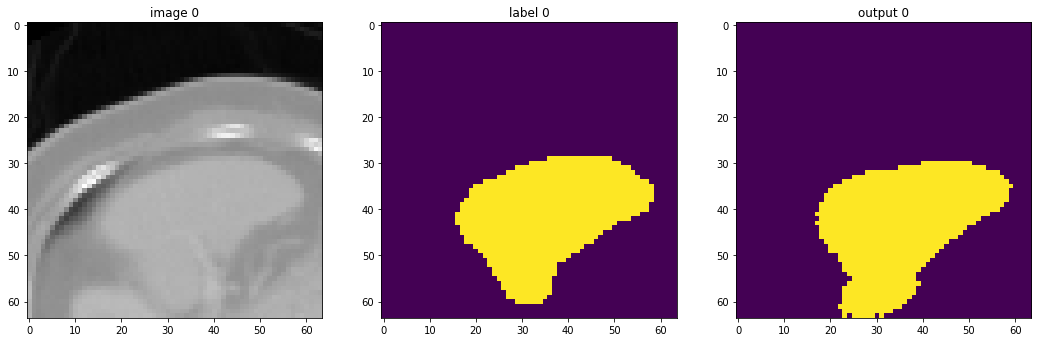

In [39]:
import matplotlib.pyplot as plt
import numpy as np
model.eval()
device = torch.device("cuda:0")
model.to(device)
ch=32
with torch.no_grad():
    for i, val_data in enumerate(model.val_dataloader()):
        roi_size = (32, 32, 32)
        sw_batch_size = 2
        output = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, ch], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, ch])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            output, dim=1).detach().cpu()[0, :, :, ch])
        plt.show()
        break
        

In [41]:
len(val_data)

8

In [42]:
from monai.data import decollate_batch
dataloader=model.val_dataloader()
model.eval()
post_data=[]
with torch.no_grad():
  for d in dataloader:
    images = d["image"].to(device)
    # define sliding window size and batch size for windows inference
    infer_outputs = sliding_window_inference(inputs=images, roi_size=(32 , 32, 32), sw_batch_size=2, predictor=model)
    infer_outputs = decollate_batch(infer_outputs)
    for (infer_output, infer_output_data) in zip(infer_outputs, decollate_batch(d)):
      infer_output_data["pred"] = infer_output
      post_data.append(post_transforms(infer_output_data))
      break
    

Loading dataset: 100%|██████████| 9/9 [00:21<00:00,  2.36s/it]


In [43]:
out=post_data[0]
out['image'].shape,out['label'].shape,out['pred'].shape

(torch.Size([1, 64, 64, 64]),
 torch.Size([1, 512, 512, 33]),
 torch.Size([2, 512, 512, 33]))

In [46]:
raw_val=val_data[0]
raw_val[0].shape,raw_val[1].shape#raw label and segment

((512, 512, 33), (512, 512, 33))

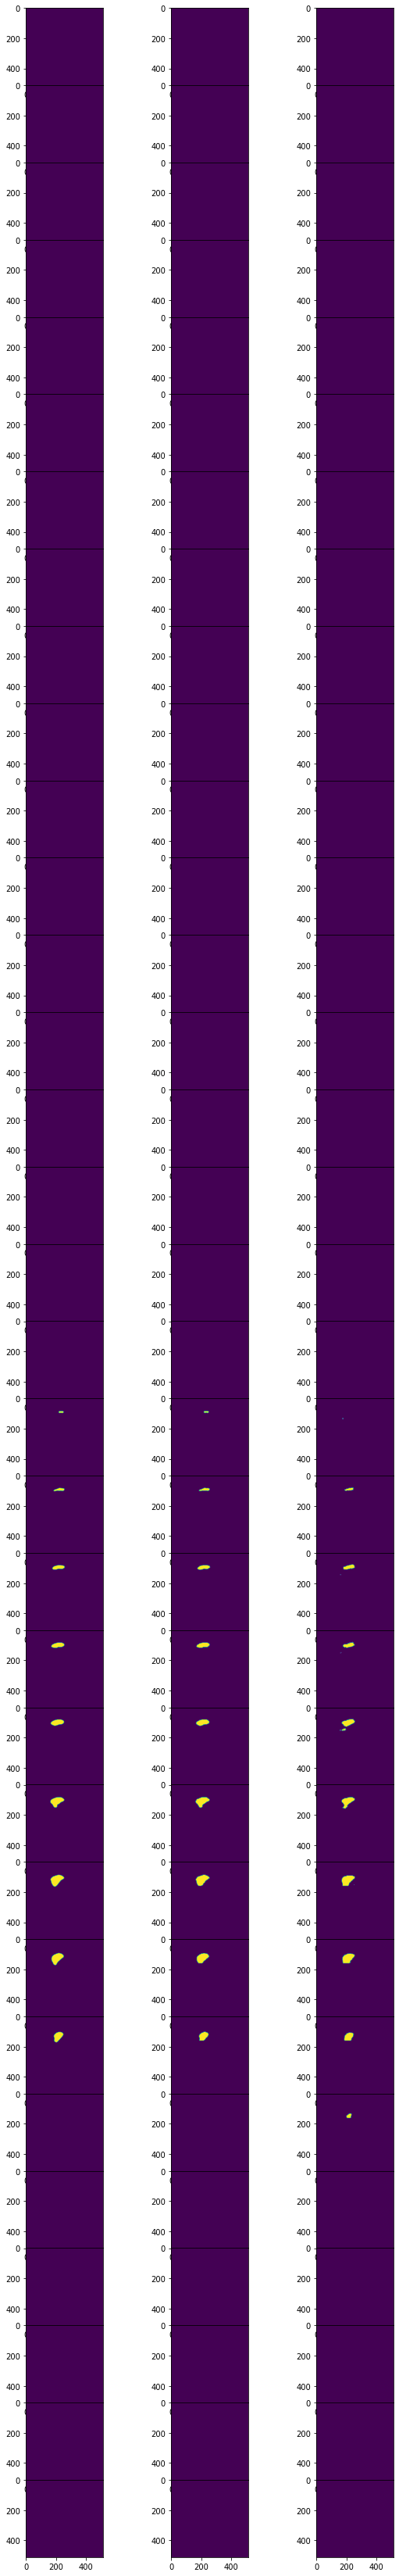

In [61]:
fig,ax=plt.subplots(33,3,figsize=(10,60))

for i in range(33):
  ax[i,0].imshow(raw_val[1][:,:,i])#raw image
  ax[i,1].imshow(out['label'][0,:,:,i])#inverted image
  ax[i,2].imshow(torch.argmax(out['pred'],0)[:,:,i])#predicted image
plt.subplots_adjust(wspace=0, hspace=0)


In [51]:
.shape

torch.Size([512, 512, 33])